In [1]:
from pathlib import Path

from fastai.vision.all import *
import cv2
matplotlib.rc('image', cmap='gray')

# Background


## Here nice [notebook of exploring the data](https://www.kaggle.com/piantic/osic-pulmonary-fibrosis-progression-basic-eda)

Data location: [OSIC pulmonary fibrosis competition](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/data?select=test)

Segmentations from: [ct-lung-heart-segmentation](https://www.kaggle.com/sandorkonya/ct-lung-heart-trachea-segmentation)

# Looking at the data

Data was downloaded from a [Kaggle Chest CT Segmentation dataset](https://www.kaggle.com/polomarco/chest-ct-segmentation), they were manually segmented using tools in [Slicer 3D](https://www.slicer.org/). More information can be found on the dataset page. Files were manually downloaded using the *Download* button then unzipping the whole contents into the `chests` directory below. You will need to change the path accordingly

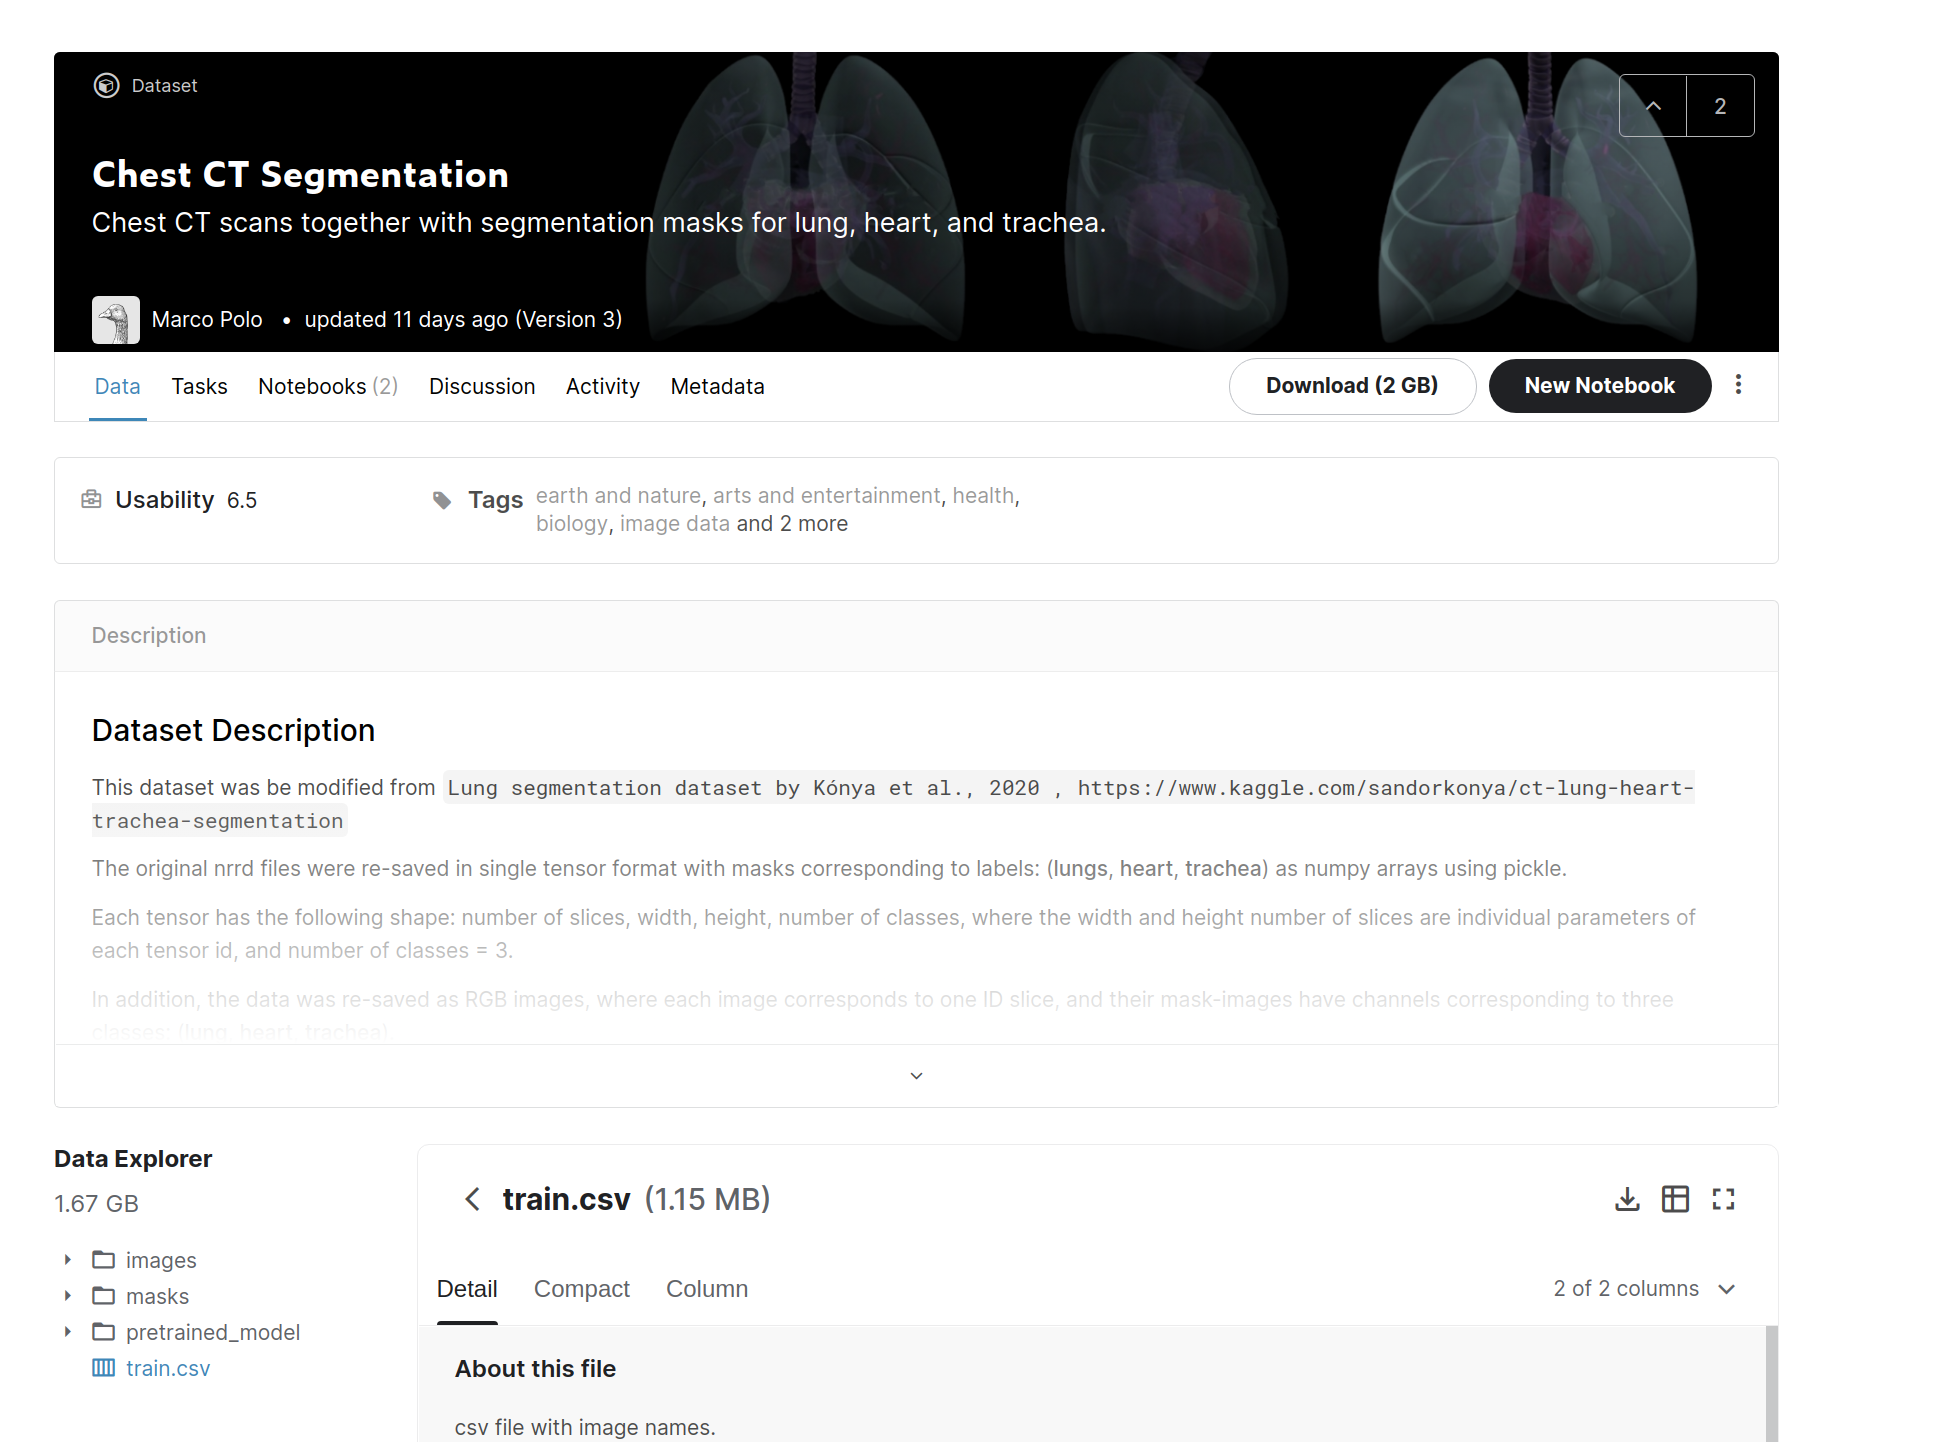

In [2]:
path = Path('/media/brandon/Data/Dev/Datasets/chests')

In [3]:
print(path.ls())
assert len(path.ls()) == 4

(#4) [Path('/media/brandon/Data/Dev/Datasets/chests/images'),Path('/media/brandon/Data/Dev/Datasets/chests/masks'),Path('/media/brandon/Data/Dev/Datasets/chests/pretrained_model'),Path('/media/brandon/Data/Dev/Datasets/chests/train.csv')]


## Data organization

The images and label filenames are given in the `train.csv`. Note: not all images are annotated, so its important to use the csv file to make sure that an equal number of images and labels are used to avoid further problems

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


An interesting feature of this particular dataset is that the classes are stored in different color channels in the saved jpg images as we can see below 

In [5]:
im_gen = (cv2.imread(str(path/'masks'/'masks'/f)) for f in df['MaskId'])

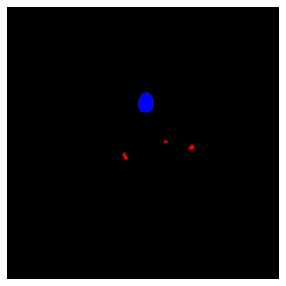

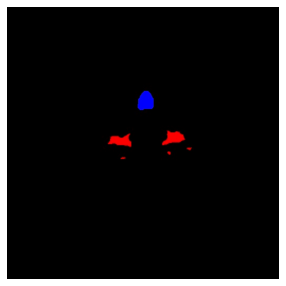

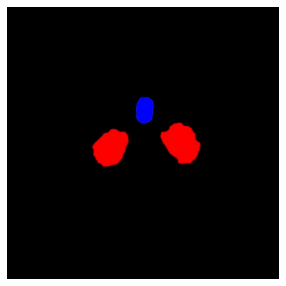

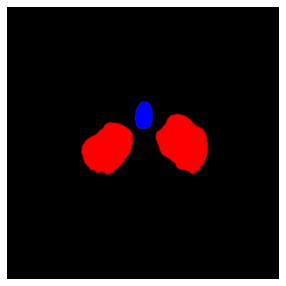

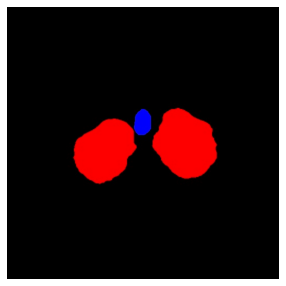

In [6]:
for i in range(5):
    show_image(next(im_gen))

In [7]:
label_shape = next(im_gen).shape
print(f'label shape: {label_shape}')
assert np.array(label_shape == (512, 512, 3)).all()

label shape: (512, 512, 3)


Here is a line from [one nice notebook](https://www.kaggle.com/polomarco/chest-ct-segmentation-lung-heart-trachea/notebook#Dataset-and-Dataloader) that successfully used this dataset. The line removes some of the jpg related artifacts mentioned in greater detail below.

In [8]:
def remove_artifacts(mask):
    m = np.copy(mask)
    m[m<240] = 0
    m[m>0] = 1
    return m

Here we seperate out each channel, stack, and sum into a single grayscale image giving each class a specific grayscale value.

In [9]:
def make_grayscale_mask(img):
    immask = remove_artifacts(img)
    graymask = np.stack([(c+1)*immask[:,:,c] for c in range(immask.shape[2])]).sum(axis=0)
    graymask[graymask>3]=3
    return graymask

This function converts all of the jpg RGB masks to PNG grayscale masks

In [10]:
def convert_masks(df, path, mask_path):
    for f in df['MaskId']:
        im = Image.open(path/'masks'/'masks'/f)
        gray_mask = np.copy(make_grayscale_mask(im))
        gray_mask[gray_mask>3] = 3
        cv2.imwrite(str(mask_path/f'{f[:-4]}.png'), gray_mask)

In [11]:
mask_path = path/'masks'/'gray_masks'
import shutil; shutil.rmtree(mask_path) #this line can be commented out to remake the grayscale masks
if not mask_path.exists():
    mask_path.mkdir()
    convert_masks(df, path, mask_path)

Here we define the codes and load them similar to the [fastai highlevel api segmentation tutorial](https://docs.fast.ai/tutorial.vision#Segmentation---Using-the-high-level-API)

In [12]:
codes = ['None','lungs', 'trachea', 'heart']

In [13]:
def get_x(r): return path/'images'/'images'/r['ImageId']
def get_y(r): return mask_path/f"{r['MaskId'][:-4]}.png"
dblock = DataBlock(blocks =(ImageBlock(), MaskBlock(codes)),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(128)
                   )
dls = SegmentationDataLoaders.from_dblock(dblock, df, bs=4)

In [14]:
len(dls.train), len(dls.valid)

(3341, 836)

In [15]:
x,y = dls.one_batch()

In [16]:
x.shape

torch.Size([4, 3, 128, 128])

# Main challenges encountered

Tha main challenges of getting this unet to train was getting a `CUDA error (710): device-side assert` which was a result of having the number of classes in the target images (i.e. the unique pixel values or `y.max()+1 > len(codes)`

This issue was encountered using this [dataset](https://www.kaggle.com/polomarco/chest-ct-segmentation-lung-heart-trachea/#data) primarily due to saving masks as `.jpg` file format *DON'T DO IT!*. The jpg compression changed the mask value unreliably. For example here we only had 4 classes:

0. other
1. trachea
2. heart
3. lung

So the maximum target mask value should be 3 and min 0, `y.max()==3`, however the [dataset](https://www.kaggle.com/polomarco/chest-ct-segmentation-lung-heart-trachea/#data) saves the masks as 3 channel RGB where each channel is a different class with the masks saved as jpgs and file names given in a .csv file. So to feed these into fastai I choose to save out a new set of grayscale images where the grayvalue corresponds to the class. It was important to save these out to PNG to preserve the value, which jpeg did not do. This is an important lesson for me in the future if a similar error comes up to always check that the range and values of the target match the codes and value range I expect. I've added the following asserts as tests of this for this particular dataset.

In [17]:
assert y.min() == 0
assert y.max() == 3

<AxesSubplot:>

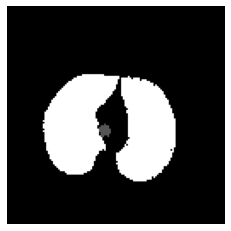

In [18]:
show_image(y[3])

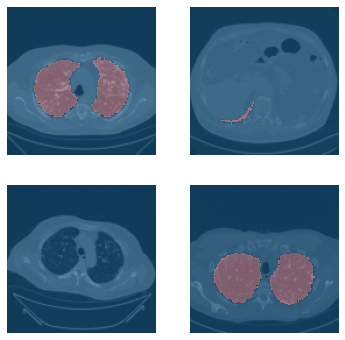

In [19]:
dls.train.show_batch(max_n=6)

In [20]:
learn = unet_learner(dls, resnet34)

In [21]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,0.069057,0.062152,04:54


epoch,train_loss,valid_loss,time
0,0.026407,0.029858,03:15
1,0.030524,0.026763,03:15
2,0.020394,0.019423,03:15
3,0.013254,0.015627,03:13
4,0.011095,0.013609,03:10
5,0.008530,0.011280,03:08
6,0.007427,0.010799,03:11
7,0.007830,0.011026,03:12


If you scroll through a couple of rounds of result there were issues in the original dataset which limit the effectiveness. For example some of the original labels are not correct but that is beyond the scope of this notebook.

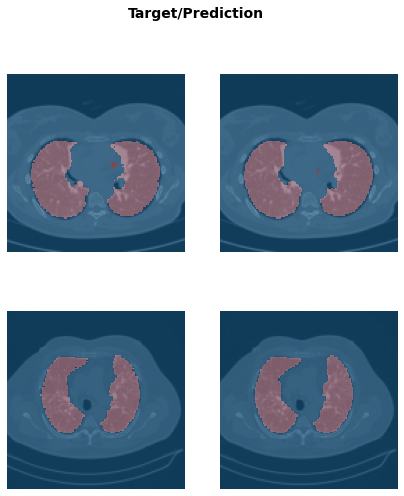

In [41]:
learn.show_results(max_n=6, figsize=(7,8))